In [1]:
!pip install torchdiffeq

In [14]:

from torchdiffeq import odeint_adjoint as odeint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os


device = torch.device( "cuda" if torch.cuda.is_available() else 'cpu')

x = torch.randn((1,2),device=device)

x

tensor([[-0.3922,  1.5430]])

In [ ]:
class TargetFunction(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self):
        return torch.mm(x)

In [15]:

class TargetFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.true_function = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)

    def forward(self, t, x):
        return torch.mm(x**3, self.true_function)

starting_point = torch.tensor([[2.0, 0.]]).to(device)
t = torch.linspace(0., 25., 1000).to(device)
target_func = TargetFunction().to(device)

with torch.no_grad():
    true_dxdt = odeint(target_func, starting_point, t)

print("> Starting point = {}".format(starting_point.squeeze()))
print("> t.shape = {}".format(t.shape))
print("> true_dxdt.shape = {}".format(true_dxdt.shape))

> Starting point = tensor([2., 0.])
> t.shape = torch.Size([1000])
> true_dxdt.shape = torch.Size([1000, 1, 2])


In [16]:
def get_batch():
    random_points = np.random.choice(np.arange(990, dtype=np.int64), 768, replace=False)
    batch_starting_point = true_dxdt[random_points]
    batch_t = t[:10]
    batch_dxdt = torch.stack([true_dxdt[random_points + i] for i in range(10)], dim=0)

    return batch_starting_point, batch_t, batch_dxdt

In [17]:

class PredictFunction(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, t, x):
        return self.net(x)

In [18]:
import matplotlib.pyplot as plt
def visualize(true_y, pred_y, odefunc, itr):
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase = fig.add_subplot(132, frameon=False)
    ax_vecfield = fig.add_subplot(133, frameon=False)
    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x,y')
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--')
    ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
    ax_traj.set_ylim(-2, 2)

    ax_phase.cla()
    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
    ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
    ax_phase.set_xlim(-2, 2)
    ax_phase.set_ylim(-2, 2)

    ax_vecfield.cla()
    ax_vecfield.set_title('Learned Vector Field')
    ax_vecfield.set_xlabel('x')
    ax_vecfield.set_ylabel('y')

    y, x = np.mgrid[-2:2:21j, -2:2:21j]
    dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax_vecfield.set_xlim(-2, 2)
    ax_vecfield.set_ylim(-2, 2)

    fig.tight_layout()
    plt.savefig('png/{:03d}.png'.format(itr))
    #plt.draw()
    #plt.pause(0.001)

> [0/3000] loss = 0.081
> [100/3000] loss = 0.067

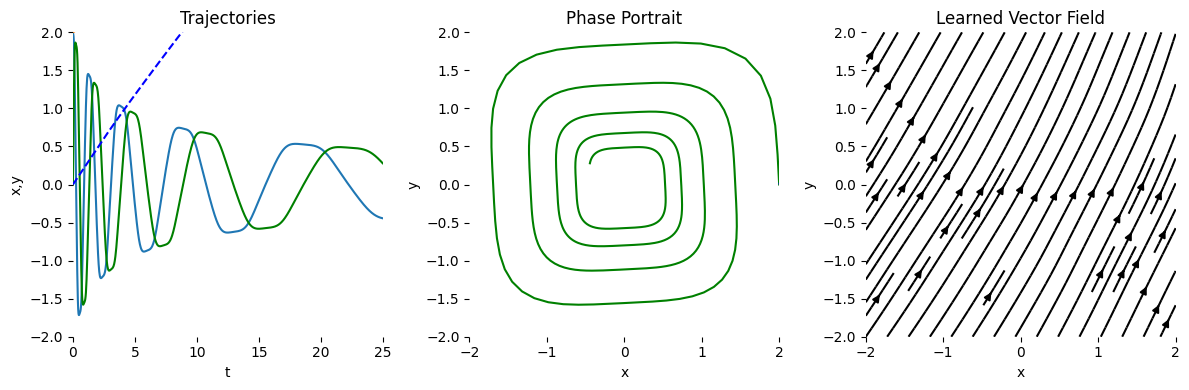

In [21]:
net = PredictFunction().to(device)
opt = optim.Adam(net.parameters(), lr=3e-4)
os.makedirs("png", exist_ok=True)

for i in range(100+1):
    opt.zero_grad()#https:\\colab.research.google.com\a93e4ab1-c004-40da-8cea-f5bcbedcbb07
    batch_starting, batch_t, batch_dxdt = get_batch()
    pred_dxdt = odeint(net, batch_starting, batch_t).to(device)
    loss = F.l1_loss(pred_dxdt, batch_dxdt)
    loss.backward()
    opt.step()
    print("\r> [{}/3000] loss = {:.3f}".format(i, loss.item()), end='')

    if i % 100 == 0:
        with torch.no_grad():
            pred_dxdt = odeint(net, starting_point, t)
            visualize(true_dxdt, pred_dxdt, net, i)
        print("")

In [46]:
import torch
import torch.nn.functional as F
hi = torch.randn(64,512)
hj = torch.randn(64,512)

# 직접 loss function으로 사용
loss =F.cosine_similarity(hi, hj,dim=0)
# print(loss)

# normalize한 후 loss function으로 사용
# hi_norm = torch.norm(hi)
hj_norm = hj / torch.norm(hj)
loss =F.cosine_similarity(hi, hj,dim=0)

# print(loss)

# hi_norm
# torch.dot(hi,hi)
# hi_norm@hi_norm.T
print('###')
# print(hi)
print('###')
# print(hi_norm[0]@hi_norm[0].T)
# 
torch.norm(hi)

###
###


tensor(181.7300)